In [1]:
import gzip
import os
import urllib
import numpy
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'


def maybe_download(filename, work_directory):
    """Download the data from Yann's website, unless it's already here."""
    if not os.path.exists(work_directory):
        os.mkdir(work_directory)
    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.urlretrieve(SOURCE_URL + filename, filepath)
        statinfo = os.stat(filepath)
        print ('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
    return filepath


def _read32(bytestream):
    dt = numpy.dtype(numpy.uint32).newbyteorder('>')
    return numpy.frombuffer(bytestream.read(4), dtype=dt)


def extract_images(filename):
    """Extract the images into a 4D uint8 numpy array [index, y, x, depth]."""
    print ('Extracting', filename)
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError(
                'Invalid magic number %d in MNIST image file: %s' %
                (magic, filename))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = numpy.frombuffer(buf, dtype=numpy.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        return data


def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = numpy.arange(num_labels) * num_classes
    labels_one_hot = numpy.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot


def extract_labels(filename, one_hot=False):
    """Extract the labels into a 1D uint8 numpy array [index]."""
    print ('Extracting', filename)
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError(
                'Invalid magic number %d in MNIST label file: %s' %
                (magic, filename))
        num_items = _read32(bytestream)
        buf = bytestream.read(num_items)
        labels = numpy.frombuffer(buf, dtype=numpy.uint8)
        if one_hot:
            return dense_to_one_hot(labels)
        return labels


class DataSet(object):
    def __init__(self, images, labels, fake_data=False):
        if fake_data:
            self._num_examples = 10000
        else:
            assert images.shape[0] == labels.shape[0], (
                "images.shape: %s labels.shape: %s" % (images.shape,
                                                       labels.shape))
            self._num_examples = images.shape[0]
            # Convert shape from [num examples, rows, columns, depth]
            # to [num examples, rows*columns] (assuming depth == 1)
            assert images.shape[3] == 1
            images = images.reshape(images.shape[0],
                                    images.shape[1] * images.shape[2])
            # Convert from [0, 255] -> [0.0, 1.0].
            images = images.astype(numpy.float32)
            images = numpy.multiply(images, 1.0 / 255.0)
        self._images = images
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size, fake_data=False):
        """Return the next `batch_size` examples from this data set."""
        if fake_data:
            fake_image = [1.0 for _ in xrange(784)]
            fake_label = 0
            return [fake_image for _ in xrange(batch_size)], [
                fake_label for _ in xrange(batch_size)]
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Shuffle the data
            perm = numpy.arange(self._num_examples)
            numpy.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self._images[start:end], self._labels[start:end]


def read_data_sets(train_dir, fake_data=False, one_hot=False):
    class DataSets(object):
        pass
    data_sets = DataSets()
    if fake_data:
        data_sets.train = DataSet([], [], fake_data=True)
        data_sets.validation = DataSet([], [], fake_data=True)
        data_sets.test = DataSet([], [], fake_data=True)
        return data_sets
    TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
    TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
    TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
    TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
    VALIDATION_SIZE = 5000
    local_file = maybe_download(TRAIN_IMAGES, train_dir)
    train_images = extract_images(local_file)
    local_file = maybe_download(TRAIN_LABELS, train_dir)
    train_labels = extract_labels(local_file, one_hot=one_hot)
    local_file = maybe_download(TEST_IMAGES, train_dir)
    test_images = extract_images(local_file)
    local_file = maybe_download(TEST_LABELS, train_dir)
    test_labels = extract_labels(local_file, one_hot=one_hot)
    validation_images = train_images[:VALIDATION_SIZE]
    validation_labels = train_labels[:VALIDATION_SIZE]
    train_images = train_images[VALIDATION_SIZE:]
    train_labels = train_labels[VALIDATION_SIZE:]
    data_sets.train = DataSet(train_images, train_labels)
    data_sets.validation = DataSet(validation_images, validation_labels)
    data_sets.test = DataSet(test_images, test_labels)
    return data_sets

In [2]:
from tensorflow.examples.tutorials.mnist import input_data


In [3]:
import imageio
# from scipy.misc import imsave
ims = imageio.imsave


In [4]:
from torchvision.ops import *

In [5]:
import numpy as np
import tensorflow as tf

class batch_norm(object):
    """Code modification of http://stackoverflow.com/a/33950177"""
    def __init__(self, epsilon=1e-5, momentum = 0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum

            self.ema = tf.train.ExponentialMovingAverage(decay=self.momentum)
            self.name = name

    def __call__(self, x, train=True):
        shape = x.get_shape().as_list()

        if train:
            with tf.variable_scope(self.name) as scope:
                self.beta = tf.get_variable("beta", [shape[-1]],
                                    initializer=tf.constant_initializer(0.))
                self.gamma = tf.get_variable("gamma", [shape[-1]],
                                    initializer=tf.random_normal_initializer(1., 0.02))

                batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments')
                ema_apply_op = self.ema.apply([batch_mean, batch_var])
                self.ema_mean, self.ema_var = self.ema.average(batch_mean), self.ema.average(batch_var)

                with tf.control_dependencies([ema_apply_op]):
                    mean, var = tf.identity(batch_mean), tf.identity(batch_var)
        else:
            mean, var = self.ema_mean, self.ema_var

        normed = tf.nn.batch_norm_with_global_normalization(
                x, mean, var, self.beta, self.gamma, self.epsilon, scale_after_normalization=True)

        return normed

# standard convolution layer
def conv2d(x, inputFeatures, outputFeatures, name):
    with tf.variable_scope(name):
        w = tf.get_variable("w",[5,5,inputFeatures, outputFeatures], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable("b",[outputFeatures], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(x, w, strides=[1,2,2,1], padding="SAME") + b
        return conv

def conv_transpose(x, outputShape, name):
    with tf.variable_scope(name):
        # h, w, out, in
        w = tf.get_variable("w",[5,5, outputShape[-1], x.get_shape()[-1]], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable("b",[outputShape[-1]], initializer=tf.constant_initializer(0.0))
        convt = tf.nn.conv2d_transpose(x, w, output_shape=outputShape, strides=[1,2,2,1])
        return convt

def deconv2d(input_, output_shape,
             k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
             name="deconv2d"):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_h, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))

        deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape, strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())

        return deconv

# leaky reLu unit
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

# fully-conected layer
def dense(x, inputFeatures, outputFeatures, scope=None, with_w=False):
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [inputFeatures, outputFeatures], tf.float32, tf.random_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [outputFeatures], initializer=tf.constant_initializer(0.0))
        if with_w:
            return tf.matmul(x, matrix) + bias, matrix, bias
        else:
            return tf.matmul(x, matrix) + bias

In [6]:
import numpy as np
import tensorflow as tf

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Instructions for updating:
Use `tf.global_variables_initializer` instead.
epoch 0: genloss 543.428833 latloss 107.026115


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


epoch 1: genloss 127.311707 latloss 16.508202


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


epoch 2: genloss 93.793991 latloss 21.982038
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


epoch 3: genloss 88.215797 latloss 23.979961


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


epoch 4: genloss 82.342865 latloss 25.336931


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


epoch 5: genloss 80.827858 latloss 24.972240


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


epoch 6: genloss 81.529396 latloss 25.489334


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


epoch 7: genloss 79.636307 latloss 25.529085


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


epoch 8: genloss 73.619255 latloss 23.680496


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


epoch 9: genloss 77.917709 latloss 25.497557


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


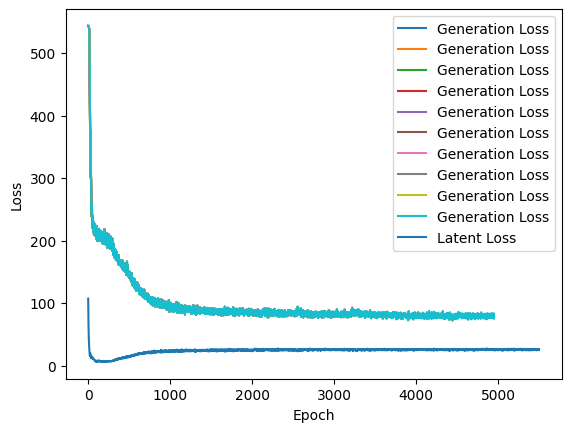

In [7]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import os
#from scipy.misc import imsave as ims
from utils import *

tf.disable_eager_execution()

class LatentAttention():
    def __init__(self):
        self.mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
        self.n_samples = self.mnist.train.num_examples

        self.n_hidden = 500
        self.n_z = 20
        self.batchsize = 100

        self.images = tf.placeholder(tf.float32, [None, 784])
        image_matrix = tf.reshape(self.images,[-1, 28, 28, 1])
        z_mean, z_stddev = self.recognition(image_matrix)
        samples = tf.random_normal([self.batchsize,self.n_z],0,1,dtype=tf.float32)
        guessed_z = z_mean + (z_stddev * samples)

        self.generated_images = self.generation(guessed_z)
        generated_flat = tf.reshape(self.generated_images, [self.batchsize, 28*28])

        self.generation_loss = -tf.reduce_sum(self.images * tf.log(1e-8 + generated_flat) + (1-self.images) * tf.log(1e-8 + 1 - generated_flat),1)

        self.latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_stddev) - tf.log(tf.square(z_stddev)) - 1,1)
        self.cost = tf.reduce_mean(self.generation_loss + self.latent_loss)
        self.optimizer = tf.train.AdamOptimizer(0.001).minimize(self.cost)


    # encoder
    def recognition(self, input_images):
        with tf.variable_scope("recognition"):
            h1 = lrelu(conv2d(input_images, 1, 16, "d_h1")) # 28x28x1 -> 14x14x16
            h2 = lrelu(conv2d(h1, 16, 32, "d_h2")) # 14x14x16 -> 7x7x32
            h2_flat = tf.reshape(h2,[self.batchsize, 7*7*32])

            w_mean = dense(h2_flat, 7*7*32, self.n_z, "w_mean")
            w_stddev = dense(h2_flat, 7*7*32, self.n_z, "w_stddev")

        return w_mean, w_stddev

    # decoder
    def generation(self, z):
        with tf.variable_scope("generation"):
            z_develop = dense(z, self.n_z, 7*7*32, scope='z_matrix')
            z_matrix = tf.nn.relu(tf.reshape(z_develop, [self.batchsize, 7, 7, 32]))
            h1 = tf.nn.relu(conv_transpose(z_matrix, [self.batchsize, 14, 14, 16], "g_h1"))
            h2 = conv_transpose(h1, [self.batchsize, 28, 28, 1], "g_h2")
            h2 = tf.nn.sigmoid(h2)

        return h2

    def train(self):
        visualization = self.mnist.train.next_batch(self.batchsize)[0]
        reshaped_vis = visualization.reshape(self.batchsize,28,28)
        ims("results/base.jpg",merge(reshaped_vis[:64],[8,8]))
        
        gen_loss_list = []
        lat_loss_list = []
        
        # train
        saver = tf.train.Saver(max_to_keep=2)
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            for epoch in range(10):
                for idx in range(int(self.n_samples / self.batchsize)):
                    batch = self.mnist.train.next_batch(self.batchsize)[0]
                    _, gen_loss, lat_loss = sess.run((self.optimizer, self.generation_loss, self.latent_loss), feed_dict={self.images: batch})
                    
                    gen_loss_list.append(np.mean(gen_loss))
                    lat_loss_list.append(np.mean(lat_loss))
                
                    # dumb hack to print cost every epoch
                    if idx % (self.n_samples - 3) == 0:
                        print("epoch %d: genloss %f latloss %f" % (epoch, np.mean(gen_loss), np.mean(lat_loss)))
                        saver.save(sess, os.getcwd()+"/training/train",global_step=epoch)
                        generated_test = sess.run(self.generated_images, feed_dict={self.images: visualization})
                        generated_test = generated_test.reshape(self.batchsize,28,28)
                        ims("results/"+str(epoch)+".jpg",merge(generated_test[:64],[8,8]))
                        
                        plt.plot(gen_loss_list, label='Generation Loss')
        plt.plot(lat_loss_list, label='Latent Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


model = LatentAttention()
model.train()

In [8]:
from PIL import Image
import numpy as np
import math

def calculate_psnr(original_image_path, processed_image_path):
    # Load images
    original_image = Image.open(original_image_path)
    processed_image = Image.open(processed_image_path)

    # Convert images to numpy arrays
    original_array = np.array(original_image).astype(np.float32)
    processed_array = np.array(processed_image).astype(np.float32)

    # Ensure the images have the same shape
    if original_array.shape != processed_array.shape:
        raise ValueError("Both images must have the same dimensions.")

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((original_array - processed_array) ** 2)

    # Calculate Peak Signal-to-Noise Ratio (PSNR)
    max_pixel_value = 255.0
    psnr = 10 * math.log10((max_pixel_value ** 2) / mse)

    return psnr

# Example usage
original_image_path = r"C:\Users\14167\Desktop\results\base.jpg"
processed_image_path = r"C:\Users\14167\Desktop\results\1.jpg"

psnr_value = calculate_psnr(original_image_path, processed_image_path)
print(f"PSNR: {psnr_value:.2f} dB")



PSNR: 14.49 dB
